### ЛАБОРАТОРНАЯ РАБОТА №3. ВСПЛЫТИЕ ПОДВОДНОЙ ЛОДКИ
**Цель работы**: изучить методы численного дифференцирования для
решения системы обыкновенных дифференциальных уравнений и применить их
на практике для решения практической задачи (определения траектории и точки
всплытия подводной лодки).



Погрешность по правилу Рунге: 6.631732200427602e-15
Коэффициенты квадратичного полинома методом наименьших квадратов: 
a = 0.38684200550711817
b = 0.007737365279371361
c = -49.999962010170805
Среднеквадратичное отклонение: 1.301880717046332e-12
[7.59796583906791e-07, 1.3887637295613676e-08, 1.3783233208819924e-08, 1.3679247568296798e-08, 1.3575679185630735e-08, 1.3472526876260087e-08, 1.3369789601569402e-08, 1.3267466326764501e-08, 1.3165556020856632e-08, 1.3064057372411785e-08, 1.2962969500111855e-08, 1.2862290957916316e-08, 1.2762020871993384e-08, 1.2662158087990208e-08, 1.2562701739510433e-08, 1.2463650395328909e-08, 1.2365003196404133e-08, 1.2266759145227507e-08, 1.216891710579129e-08, 1.2071475945701584e-08, 1.1974434536161289e-08, 1.187779203626725e-08, 1.178154718223178e-08, 1.1685698998129671e-08, 1.1590246511587172e-08, 1.1495188753767552e-08, 1.1400524190625112e-08, 1.1306252286850415e-08, 1.1212371941916382e-08, 1.1118882058749576e-08, 1.1025781401506382e-08, 1.0933069022166

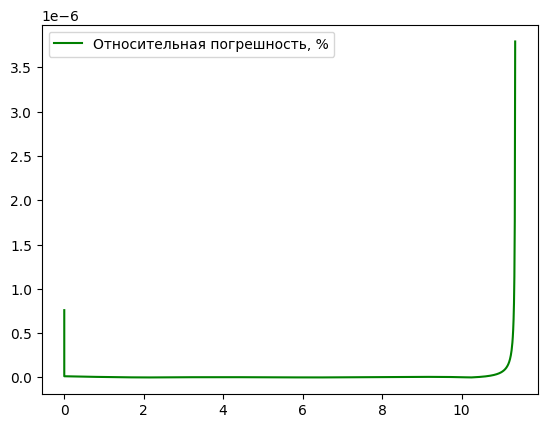

In [217]:
from typing import Callable, List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# Дано
eta = 0.001
rho0 = 1025
g = 9.8
alpha = 0.01
rho1 = 950

# Задать самому
V = 900 # объём
S = 180 # площадь
l = V/S # длина
H = 50 # глубина
v = 25 # скорость

k = S / l

# Метод Рунге–Кутта 4 порядка
def rk4(f: Callable[[float, np.ndarray], np.ndarray], a: float, b: float, y0: np.ndarray, h: int) -> Tuple[np.ndarray, np.ndarray]:
    m = len(y0)
    # h = (b - a) / n
    x = np.arange(a, b, h)
    n = len(x)
    y = np.zeros((n, m))
    
    k1 = h * f(a, y0)
    k2 = h * f(a + h/2, y0 + k1/2)
    k3 = h * f(a + h/2, y0 + k2/2)
    k4 = h * f(a + h, y0 + k3)
    
    y[0, :] = y0 + k1/6 + k2/3 + k3/3 + k4/6
    
    for i in range(n - 1):
        k1 = h * f(x[i], y[i, :])
        k2 = h * f(x[i] + h/2, y[i, :] + k1/2)
        k3 = h * f(x[i] + h/2, y[i, :] + k2/2)
        k4 = h * f(x[i] + h, y[i, :] + k3)
        y[i + 1, :] = y[i, :] + k1/6 + k2/3 + k3/3 + k4/6
    
    x = np.concatenate(([a], x))
    y = np.concatenate((y0.reshape(1, m), y))
    
    return x, y


# Функция для системы уравнений
def submarine_sys(t: float, y: np.ndarray):
    dy = y[1]
    dz = -(eta*k / (V*rho1)) * (1 + alpha*y[0]/H)*dy + g*(rho0/rho1-1)
    return np.array([dy, dz])

# Начальные условия
y0 = np.array([-H, 0])
a = 0
b = 15
# n= 10000
h = 0.01
# Решение системы дифференциальных уравнений
solution: Tuple[np.ndarray, np.ndarray] = rk4(submarine_sys, a, b, y0, h)

# Убираем значения, где y0 > 0
# solution_x = solution[0]
# solution_y = solution[1]
solution_x = solution[0][solution[1][:, 0] <= 0]
solution_y = solution[1][solution[1][:, 0] <= 0]

half =  rk4(submarine_sys, a, b, y0, h / 2)
# half_x = half[0]
# half_y = half[1]
half_x = half[0][half[1][:, 0] <= 0]
half_y = half[1][half[1][:, 0] <= 0]

runge_errs = [solution_y[:, 0][i] - half_y[:, 0][i * 2] for i in range(len(solution_y[:,0]))]
runge_err = max(runge_errs) / 15
print(f"Погрешность по правилу Рунге: {runge_err}")
# Функция для аппроксимации методом наименьших квадратов
def gaussian_elimination(matrix: np.ndarray, vector: np.array) -> np.ndarray:
    n = len(vector)
    
    # Прямой ход метода Гаусса
    for i in range(n-1):
        pivot = matrix[i, i]    
        for k in range(i+1, n):
            factor = matrix[k, i] / pivot
            matrix[k, i:] -= factor * matrix[i, i:]
            vector[k] -= factor * vector[i]

    # Обратный ход метода Гаусса
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (vector[i] - np.dot(matrix[i, i+1:], x[i+1:])) / matrix[i, i]

    return x

def approx(x: np.ndarray, y: np.array, degree: int) -> np.ndarray:
    n: int = len(x)
    X: np.ndarray = np.ones((n, degree + 1))
    for i in range(1, degree + 1):
        X[:, i] = x ** i
    coefficients: np.ndarray = gaussian_elimination(np.dot(X.T, X), np.dot(X.T, y))
    return coefficients

# Аппроксимация решения и получение коэффициентов полинома
degree = 2
c,b,a = approx(solution_x, solution_y[:, 0], degree)
print("Коэффициенты квадратичного полинома методом наименьших квадратов: ")
print(f"a = {a}")
print(f"b = {b}")
print(f"c = {c}")
def f_approx(t):
    return a * t**2 + b*t + c

# Вычисление среднеквадратичного отклонения 
t_approx = list(solution_x)
y_approx = [f_approx(t) for t in t_approx]
abs_errs = [abs(y_approx[i] - solution_y[:, 0][i]) for i in range(len(solution_y[:,0]))]
rel_errs = [abs(abs_errs[i] / solution_y[:,0][i]) for i in range(len(abs_errs))]
std_err = sum([e**2 for e in abs_errs]) / len(abs_errs)
print(f'Среднеквадратичное отклонение: {std_err}')

print(rel_errs)
plt.plot(t_approx, rel_errs, color="green", label="Относительная погрешность, %" )
plt.legend()
plt.show()

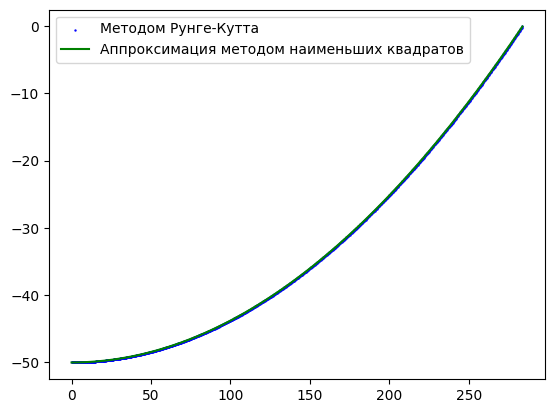

Время всплытия (T): [11.35889266]
Абсцисса точки всплытия (L): [283.97231658]


In [218]:

# Построение графика аппроксимации функции
t_plot = np.linspace(0, np.max(solution_x), 100)
y_plot = [f_approx(t) for t in t_plot]
plt.scatter(solution_x * v, solution_y[:, 0], color="blue", marker="o", s=0.5, label="Методом Рунге-Кутта")
plt.plot(t_plot * v, y_plot, color="green", label="Аппроксимация методом наименьших квадратов" )
plt.legend()
plt.show()

# Определение времени всплытия и точки всплытия
def get_time(a: float, b: float, c: float, H: float) -> float:
    roots = np.roots([a, b, c - H])
    real_roots = np.real(roots[np.abs(np.imag(roots)) < 1e-6])
    return real_roots[real_roots > 0]

T = get_time(a, b, c, 0)
L = v * T

# Вывод значений
print("Время всплытия (T):", T)
print("Абсцисса точки всплытия (L):", L)